<a href="https://colab.research.google.com/github/JordanFoss/STAT3007_Project/blob/main/TimeDistributedCNN%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
!git clone https://github.com/JordanFoss/STAT3007_Project.git
%cd STAT3007_Project/

fatal: destination path 'STAT3007_Project' already exists and is not an empty directory.
/content/STAT3007_Project


In [39]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
import scipy
import numpy as np
import librosa
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import pandas as pd
import glob

In [41]:
# fourier transform
def spectral_decomposition(sample,sampling_rate, eps = 1e-14, title = ' title placeholder', visualise = False):
    frequencies, times, spectrogram = scipy.signal.spectrogram(sample,fs = sampling_rate)

    
    
    
    if visualise:
      specgram = plt.pcolormesh(times, frequencies, np.log(spectrogram + eps),shading = 'auto')
      plt.clim(-40, -5)
      
      plt.colorbar(specgram)
      #plt.imshow(np.log(spectrogram))
      plt.ylabel('Frequency [Hz]')
      plt.xlabel('Time [sec]')
      plt.title(title)
      plt.show()
    
    return frequencies, times, np.log(spectrogram+ eps)

In [42]:
# template
class TimeDistributed(nn.Module):
    def __init__(self, segments):
        super(TimeDistributed, self).__init__()

        self.segments = segments
        self.flatten = nn.Flatten()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size = 3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride = 2),
            nn.Conv2d(32, 32, kernel_size = 3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride = 2),
        )


        self.lstm_layer = nn.LSTM(1024,100,2)
        self.linear = nn.Sequential(nn.Linear(100, 5),
                                    nn.Sigmoid())

    def forward(self, x, use_cuda = False):

      # initial cell/hidden state
      # (num_layers, batch, hidden_size)
      if use_cuda:
        h_t = torch.zeros(2,1 ,100, dtype=torch.float).to(x.device)
        c_t = torch.zeros(2,1, 100, dtype=torch.float).to(x.device)

      else:
        h_t = torch.zeros(2,1, 100, dtype=torch.float)
        c_t = torch.zeros(2,1, 100, dtype=torch.float)

      # generate output of each prediction based on input
      start = 0
      step_size = int((x.shape[1]/self.segments))
      end = step_size

      for segment in range(segments):
        
        input_t = x[:,start:end]

        start = end
        end = end + step_size

        input_t = self.conv(input_t)
        input_t = self.flatten(input_t)
        # send info of previous cell/hidden state to the next layer
        # input the next character on the provided sequence
        h_t, c_t = self.lstm(input_t, (h_t, c_t))
        output = self.linear(h_t)
      
      return outputs

In [43]:
# produce emotion label

# 0 - calm; 1 - happy; 2 - sad; 3 - angry; 4 - surprised
target_map = {'02':0,'03':1,'04':2,'05':3,'08':4}

def target_generation(file_name):
  labels = file_name.split('.')[0].split('-')
  emotion = labels[0]

  if emotion not in target_map:
    return None

  return target_map[emotion]

In [44]:
# load samples
X = []
y = []

min_time = 41241

max_time = 0
max_sample = 0
for folder_name in glob.glob('./Audio_Speech_Actors_01-24/*'):
  for actor_folder in glob.glob(folder_name + '/*'):
    for sample_path in glob.glob(actor_folder + '/*'):
      
      sample_name = sample_path.split('/')[-1]
      file_format = sample_name.split('.')[-1]

      if file_format != 'wav' or sample_name[:2] not in target_map or sample_name[3:5] == '01':
        continue

      sample, sampling_rate = librosa.load(sample_path, sr = None)
      sampling_time = sample.shape[0]/sampling_rate

      frequencies, times, spectrogram = spectral_decomposition(sample, sampling_rate)

      if sampling_time < min_time:
        min_time = sampling_time
        min_sample = (sample,sampling_rate, sample_path)

      if sampling_time > max_time:
        max_time = sampling_time
        max_sample = (sample,sampling_rate, sample_path)
      
      target = target_generation(sample_name)

      if target != None:
        X.append(spectrogram)
        y.append(target)
    


./Audio_Speech_Actors_01-24/Male
./Audio_Speech_Actors_01-24/Female


# Pre-Process

##Current Problem
The time steps for speech data is not the same.

proposed solution:
1. test data - no changes
2. training data - pad all the samples to max length. Since we want our network to be independent of audio length, we can do data augmentation to break them apart. (source https://arxiv.org/pdf/1607.02857.pdf)

3. must read: effect of padding on CNN and LSTM (https://arxiv.org/pdf/1903.07288.pdf)
 * Acoording to the paper, prepadding is good for LSTM and CNN. So we choose __pre-padding__ the samples


In [29]:
print(max_time)
print(max_sample[2])
print(min_time)
print(min_sample[2])

5.105104166666667
./Audio_Speech_Actors_01-24/Female/Actor_24/05-02-02-02-24.wav
3.003
./Audio_Speech_Actors_01-24/Male/Actor_13/02-02-02-01-13.wav


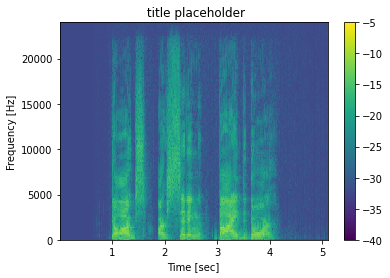

In [9]:
a,b,c = spectral_decomposition(max_sample[0],max_sample[1],visualise = True)

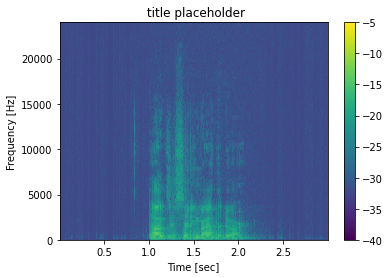

In [82]:
a,b,c = spectral_decomposition(min_sample[0],min_sample[1],visualise = True)

## Padding

In [45]:
# find maximum and minimum duration
def find_min_max():

  min_time = 41241
  max_time = 0
  min_sample = 0
  max_sample = 0
  for folder_name in glob.glob('./Audio_Speech_Actors_01-24/*'):
    for actor_folder in glob.glob(folder_name + '/*'):
      for sample_path in glob.glob(actor_folder + '/*'):
        sample_name = sample_path.split('/')[-1]
        file_format = sample_name.split('.')[-1]
        if file_format != 'wav' or sample_name[:2] not in target_map or sample_name[3:5] == '01':
          continue
        
        sample, sampling_rate = librosa.load(sample_path, sr = None)
        sampling_time = sample.shape[0]/sampling_rate

        if sampling_time < min_time:
          min_time = sampling_time
          min_sample = sample.shape[0]

        if sampling_time > max_time:
          max_time = sampling_time
          max_sample = sample.shape[0]

  return min_time, max_time, min_sample, max_sample

In [46]:
min_time, max_time, min_sample, max_sample = find_min_max()

In [72]:
max_sample

245045


Now that we have the maximum duration of the dataset, we can start pre-padding

In [47]:
def pre_pad(samples, max_sample):
  sample_duration = samples.shape[0]

  num_to_pad = max_sample - sample_duration
  padded_sample = np.pad(samples,(num_to_pad,0),'constant', constant_values = 0)

  return padded_sample

In [48]:
def load_samples(max_sample):
  # load samples
  X = []
  y = []

  for folder_name in glob.glob('./Audio_Speech_Actors_01-24/*'):
    for actor_folder in glob.glob(folder_name + '/*'):
      for sample_path in glob.glob(actor_folder + '/*'):
        
        sample_name = sample_path.split('/')[-1]
        file_format = sample_name.split('.')[-1]

        if file_format != 'wav' or sample_name[:2] not in target_map or sample_name[3:5] == '01':
          continue

        sample, sampling_rate = librosa.load(sample_path, sr = None)
        
        padded_sample = pre_pad(sample, max_sample)



        frequencies, times, spectrogram = spectral_decomposition(padded_sample, sampling_rate)
        
        target = target_generation(sample_name)

        if target != None:
          X.append(spectrogram)
          y.append(target)
  
  return X, y


In [49]:
X,y = load_samples(max_sample)

## Clean-up data

In [51]:
# convert torch type
X = torch.tensor(X)
X = X.reshape(X.shape[0],1,X.shape[1],X.shape[2])

y = torch.tensor(y)

# Architecture building

1. build a CNN
2. build a RNN embedded with CNN

In [90]:
# convolutional net
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.flatten = nn.Flatten()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size = 3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride = 2),
            nn.Conv2d(32, 32, kernel_size = 3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride = 2),
        )

    def forward(self, x):

      conv_x = self.conv(x)
      conv_x_flat  = self.flatten(conv_x)

      return conv_x_flat

In [91]:
CNN = ConvNet()
cnn_out = CNN(X[:30,:,:,:129])

In [89]:
# RNN combined with CNN
class LSRCN(nn.Module):
    def __init__(self, num_inputs):
        super(LSRCN, self).__init__()

        self.lstm_layers = nn.LSTM(num_inputs,100,2)
        self.linear = nn.Sequential(nn.Linear(100, 5),
                                    nn.Sigmoid())

    def forward(self, x,CNN, step_size, use_cuda = False):

      if use_cuda:
        h_t = torch.zeros(2,1 ,100, dtype=torch.float).to(x.device)
        c_t = torch.zeros(2,1, 100, dtype=torch.float).to(x.device)

      else:
        h_t = torch.zeros(2,1, 100, dtype=torch.float)
        c_t = torch.zeros(2,1, 100, dtype=torch.float)

      current_time = 0
      for look_ahead_time in range(step_size-1,x.shape[3]+1, step_size):
        x_t = x[:,:,:,current_time:look_ahead_time]
        current_time = look_ahead_time
        conv_x_flat = CNN(x_t)
        h_t, c_t = self.lstm(conv_x_flat, (h_t, c_t))
        
      output = self.linear(h_t[1])
      return output